In [1]:
import pandas as pd
import requests
import re

In [2]:
# adjust the path to your file
file_path = 'co-est2024-pop.xlsx'

# 1) Read only col A (0) and col G (6), skipping the first 5 rows so row 6 becomes our first data row
df = pd.read_excel(
    file_path,
    header=None,
    usecols=[0, 6],
    skiprows=5,
    names=['County', 'Pop2024']
)

# 2) Filter counties with 2024 pop between 20k and 100k
mask = df['Pop2024'].between(20000, 100000)
result_df = df.loc[mask, ['County', 'Pop2024']]

# 3) Sort from highest to lowest population
result_sorted = result_df.sort_values('Pop2024', ascending=False)

# 4) Print as a Markdown table
print(result_sorted)
print(result_sorted.shape)

                             County  Pop2024
137       .Garland County, Arkansas  99902.0
2059       .Columbiana County, Ohio  99823.0
1070      .Madison County, Kentucky  99582.0
821           .Dubuque County, Iowa  99242.0
2881   .Montgomery County, Virginia  98998.0
...                             ...      ...
1118  .Assumption Parish, Louisiana  20050.0
2613        .Gonzales County, Texas  20040.0
2769         .Willacy County, Texas  20027.0
1811    .Lincoln County, New Mexico  20025.0
723         .Fulton County, Indiana  20004.0

[1207 rows x 2 columns]
(1207, 2)


In [3]:
# adjust the path to your file
file_path = 'SUB-IP-EST2024-POP.xlsx'

# 1) Read only col A (0) and col G (6), skipping the first 5 rows so row 6 becomes our first data row
df = pd.read_excel(
    file_path,
    header=None,
    usecols=[0, 6],
    skiprows=5,
    names=['Place', 'Pop2024']
)

# 2) Filter places with 2024 pop between 20k and 100k
mask = df['Pop2024'].between(20000, 100000)
result_df = df.loc[mask, ['Place', 'Pop2024']]

# 3) Sort from highest to lowest population
result_sorted = result_df.sort_values('Pop2024', ascending=False)

result_df

,Place,Pop2024
3,"Alabaster city, Alabama",34460.0
4,"Albertville city, Alabama",23392.0
11,"Anniston city, Alabama",21127.0
20,"Athens city, Alabama",32587.0
23,"Auburn city, Alabama",83757.0
...,...,...
19392,"Casper city, Wyoming",58823.0
19393,"Cheyenne city, Wyoming",65704.0
19413,"Gillette city, Wyoming",33846.0
19431,"Laramie city, Wyoming",32957.0


In [4]:
result_df['type'] = result_df['Place'].str.split(',').str[0].str.split().str[-1]
result_df['type'].unique()

array(['city', 'borough', 'town', '(balance)', 'village', 'City',
       'Princeton', 'municipality', 'township'], dtype=object)

In [5]:
city_df = result_df[(result_df['type'] == 'City') | (result_df['type'] == 'city')]
city_df

,Place,Pop2024,type
3,"Alabaster city, Alabama",34460.0,city
4,"Albertville city, Alabama",23392.0,city
11,"Anniston city, Alabama",21127.0,city
20,"Athens city, Alabama",32587.0,city
23,"Auburn city, Alabama",83757.0,city
...,...,...,...
19392,"Casper city, Wyoming",58823.0,city
19393,"Cheyenne city, Wyoming",65704.0,city
19413,"Gillette city, Wyoming",33846.0,city
19431,"Laramie city, Wyoming",32957.0,city


In [6]:
#density calculation 
import requests, zipfile, io

url = 'https://www2.census.gov/geo/docs/maps-data/data/gazetteer/2024_Gazetteer/2024_Gaz_place_national.zip'
resp = requests.get(url)
with zipfile.ZipFile(io.BytesIO(resp.content)) as z:
    gazetteer = pd.read_csv(
        z.open('2024_Gaz_place_national.txt'),
        sep='\t',
        #usecols=['NAME', 'ALAND_SQMI'],
        dtype={'NAME': str}
    )



In [7]:
places_df = result_df.copy()
gazetteer_df = gazetteer.copy()

In [8]:
state_to_usps = {
    "Alabama":"AL","Alaska":"AK","Arizona":"AZ","Arkansas":"AR","California":"CA","Colorado":"CO",
    "Connecticut":"CT","Delaware":"DE","District of Columbia":"DC","Florida":"FL","Georgia":"GA",
    "Hawaii":"HI","Idaho":"ID","Illinois":"IL","Indiana":"IN","Iowa":"IA","Kansas":"KS","Kentucky":"KY",
    "Louisiana":"LA","Maine":"ME","Maryland":"MD","Massachusetts":"MA","Michigan":"MI","Minnesota":"MN",
    "Mississippi":"MS","Missouri":"MO","Montana":"MT","Nebraska":"NE","Nevada":"NV","New Hampshire":"NH",
    "New Jersey":"NJ","New Mexico":"NM","New York":"NY","North Carolina":"NC","North Dakota":"ND",
    "Ohio":"OH","Oklahoma":"OK","Oregon":"OR","Pennsylvania":"PA","Rhode Island":"RI",
    "South Carolina":"SC","South Dakota":"SD","Tennessee":"TN","Texas":"TX","Utah":"UT","Vermont":"VT",
    "Virginia":"VA","Washington":"WA","West Virginia":"WV","Wisconsin":"WI","Wyoming":"WY"
}

# --- 3) Helpers to normalize names ---
def normalize_name(s: str) -> str:
    if pd.isna(s):
        return ""
    s = s.lower().strip()
    s = re.sub(r"[’'`]", "", s)         # remove apostrophes
    s = re.sub(r"\s+", " ", s)          # collapse spaces
    return s

def extract_place_and_state(place: str):
    """
    'Alabaster city, Alabama' -> ('Alabaster city', 'Alabama')
    Handles occasional extra commas/spaces.
    """
    if pd.isna(place):
        return "", ""
    parts = [p.strip() for p in str(place).rsplit(",", 1)]
    if len(parts) == 2:
        city, state = parts
    else:
        # fallback: no comma found
        city, state = place.strip(), ""
    return city, state

# --- 4) Prepare places_df: split place & map state to USPS ---
tmp = places_df['Place'].apply(extract_place_and_state).apply(pd.Series)
tmp.columns = ['city_raw', 'state_raw']
places_df = places_df.join(tmp)

# If 'state_raw' is already a 2-letter USPS, keep it; else map from full name.
def to_usps(s):
    if isinstance(s, str) and len(s) == 2 and s.isupper():
        return s
    return state_to_usps.get(s, None)

places_df['USPS'] = places_df['state_raw'].apply(to_usps)

# normalized city name for joining
places_df['city_norm'] = places_df['city_raw'].apply(normalize_name)

# --- 5) Prepare gazetteer_df: normalized city name (from NAME), deduplicate by USPS+NAME ---
gazetteer_df['name_norm'] = gazetteer_df['NAME'].apply(normalize_name)

# Keep the row with largest ALAND when duplicates exist (same USPS + name_norm)
gazetteer_dedup = (
    gazetteer_df.sort_values('ALAND', ascending=False)
                .drop_duplicates(subset=['USPS','name_norm'], keep='first')
)

# --- 6) Select area fields to bring over ---
gaz_keep = gazetteer_dedup[['USPS','name_norm','ALAND_SQMI','AWATER_SQMI','ALAND','AWATER']].copy()
gaz_keep = gaz_keep.rename(columns={'name_norm':'city_norm'})

# --- 7) Left-join on [USPS, city_norm] ---
merged_density = places_df.merge(
    gaz_keep,
    on=['USPS','city_norm'],
    how='left',
    validate='m:1'  # each place should match at most one gazetteer row
)

# --- 8) Compute area outputs ---
merged_density['area_sqmi'] = merged_density['ALAND_SQMI']          # land area (sq mi)
merged_density['area_total_sqmi'] = merged_density['ALAND_SQMI'].fillna(0) + merged_density['AWATER_SQMI'].fillna(0)


In [9]:
merged_density

,Place,Pop2024,type,city_raw,state_raw,USPS,city_norm,ALAND_SQMI,AWATER_SQMI,ALAND,AWATER,area_sqmi,area_total_sqmi
0,"Alabaster city, Alabama",34460.0,city,Alabaster city,Alabama,AL,alabaster city,26.255,0.317,68000038,820693,26.255,26.572
1,"Albertville city, Alabama",23392.0,city,Albertville city,Alabama,AL,albertville city,26.972,0.094,69856181,244058,26.972,27.066
2,"Anniston city, Alabama",21127.0,city,Anniston city,Alabama,AL,anniston city,45.850,0.070,118751122,180468,45.850,45.920
3,"Athens city, Alabama",32587.0,city,Athens city,Alabama,AL,athens city,41.838,0.289,108360634,748132,41.838,42.127
4,"Auburn city, Alabama",83757.0,city,Auburn city,Alabama,AL,auburn city,62.949,1.034,163038014,2678555,62.949,63.983
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1576,"Casper city, Wyoming",58823.0,city,Casper city,Wyoming,WY,casper city,26.753,0.335,69290824,866721,26.753,27.088
1577,"Cheyenne city, Wyoming",65704.0,city,Cheyenne city,Wyoming,WY,cheyenne city,36.474,0.112,94467889,290954,36.474,36.586
1578,"Gillette city, Wyoming",33846.0,city,Gillette city,Wyoming,WY,gillette city,23.192,0.038,60066932,99326,23.192,23.230
1579,"Laramie city, Wyoming",32957.0,city,Laramie city,Wyoming,WY,laramie city,18.495,0.023,47901342,59518,18.495,18.518


In [10]:
city_density = merged_density[(merged_density['type'] == 'City') | (merged_density['type'] == 'city')]
city_density 

,Place,Pop2024,type,city_raw,state_raw,USPS,city_norm,ALAND_SQMI,AWATER_SQMI,ALAND,AWATER,area_sqmi,area_total_sqmi
0,"Alabaster city, Alabama",34460.0,city,Alabaster city,Alabama,AL,alabaster city,26.255,0.317,68000038,820693,26.255,26.572
1,"Albertville city, Alabama",23392.0,city,Albertville city,Alabama,AL,albertville city,26.972,0.094,69856181,244058,26.972,27.066
2,"Anniston city, Alabama",21127.0,city,Anniston city,Alabama,AL,anniston city,45.850,0.070,118751122,180468,45.850,45.920
3,"Athens city, Alabama",32587.0,city,Athens city,Alabama,AL,athens city,41.838,0.289,108360634,748132,41.838,42.127
4,"Auburn city, Alabama",83757.0,city,Auburn city,Alabama,AL,auburn city,62.949,1.034,163038014,2678555,62.949,63.983
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1576,"Casper city, Wyoming",58823.0,city,Casper city,Wyoming,WY,casper city,26.753,0.335,69290824,866721,26.753,27.088
1577,"Cheyenne city, Wyoming",65704.0,city,Cheyenne city,Wyoming,WY,cheyenne city,36.474,0.112,94467889,290954,36.474,36.586
1578,"Gillette city, Wyoming",33846.0,city,Gillette city,Wyoming,WY,gillette city,23.192,0.038,60066932,99326,23.192,23.230
1579,"Laramie city, Wyoming",32957.0,city,Laramie city,Wyoming,WY,laramie city,18.495,0.023,47901342,59518,18.495,18.518


In [35]:
API_KEY = "0291ed453c49b88aafdb6d6d12bac47801f0e6f5"

subject_var = "S0101_C01_001E"   # total population
profile_var = "DP02_0018E"       # population in households
income_var = "S1903_C03_001E"   # median household income (2023 inflation-adjusted $)
extra_subject_vars = [
    "S0101_C01_032E",  # median age (years)
    "S0101_C01_033E",  # sex ratio (males per 100 females)
    "S0101_C01_034E",  # age dependency ratio
    "S0101_C01_035E",  # old-age dependency ratio
    "S0101_C01_036E",  # child dependency ratio
]
subject_vars = [subject_var, income_var] + extra_subject_vars

subject_url = (
    f"https://api.census.gov/data/2023/acs/acs5/subject"
    f"?get=NAME,{','.join(subject_vars)}"
    f"&for=place:*&in=state:*"
    f"&key={API_KEY}"
)

# build URLs

profile_url = (
    f"https://api.census.gov/data/2023/acs/acs5/profile"
    f"?get=NAME,{profile_var}"
    f"&for=place:*&in=state:*"
    f"&key={API_KEY}"
)




# fetch subject table (now includes population, income, and the 5 ratios)
resp_subj = requests.get(subject_url)
resp_subj.raise_for_status()
data_subj = resp_subj.json()
df_subj = pd.DataFrame(data_subj[1:], columns=data_subj[0])

# cast numerics
for v in subject_vars:
    df_subj[v] = pd.to_numeric(df_subj[v], errors="coerce")

# profile fetch unchanged
resp_prof = requests.get(profile_url)
resp_prof.raise_for_status()
data_prof = resp_prof.json()
df_prof = pd.DataFrame(data_prof[1:], columns=data_prof[0])
df_prof[profile_var] = pd.to_numeric(df_prof[profile_var], errors="coerce")

# merge
acs_df = df_subj.merge(df_prof, on=["NAME", "state", "place"])

# rename to friendly column names
rename_map = {
    "NAME": "Place",
    subject_var: "total_population",
    profile_var: "pop_in_households",
    income_var:  "median_household_income",
    "S0101_C01_032E": "median_age",
    "S0101_C01_033E": "sex_ratio",
    "S0101_C01_034E": "age_dependency_ratio",
    "S0101_C01_035E": "old_age_dependency_ratio",
    "S0101_C01_036E": "child_dependency_ratio",
}

acs_df = acs_df.rename(columns=rename_map)

In [36]:
acs_df

,Place,total_population,median_household_income,median_age,sex_ratio,age_dependency_ratio,old_age_dependency_ratio,child_dependency_ratio,state,place,pop_in_households
0,"Abanda CDP, Alabama",48,-666666666,32.4,128.6,242.9,92.9,150.0,01,00100,48.0
1,"Abbeville city, Alabama",2470,32778,55.3,101.8,110.8,74.7,36.1,01,00124,2313.0
2,"Adamsville city, Alabama",4291,60564,47.6,98.7,67.1,32.4,34.7,01,00460,4278.0
3,"Addison town, Alabama",651,54911,40.5,93.8,64.0,29.2,34.8,01,00484,651.0
4,"Akron town, Alabama",354,43375,37.1,128.4,41.0,12.0,29.1,01,00676,354.0
...,...,...,...,...,...,...,...,...,...,...,...
32320,"Voladoras comunidad, Puerto Rico",1056,18929,39.4,118.6,81.8,36.3,45.4,72,87638,NaN
32321,"Yabucoa zona urbana, Puerto Rico",5740,17511,43.9,84.3,74.1,39.7,34.4,72,87863,NaN
32322,"Yauco zona urbana, Puerto Rico",14903,22777,44.2,85.2,69.2,38.4,30.8,72,88035,NaN
32323,"Yaurel comunidad, Puerto Rico",674,13058,55.6,92.6,67.7,51.0,16.7,72,88121,NaN


In [39]:
merged = city_density.merge(
    acs_df[["Place", "total_population", "pop_in_households", "median_household_income", "median_age", "sex_ratio", "age_dependency_ratio", 'old_age_dependency_ratio', 'child_dependency_ratio']],
    on="Place",
    how="left"
)
merged["pct_diff"] = (
    (merged["pop_in_households"] - merged["total_population"])
    / merged["total_population"]
) * 100


In [54]:
merged

,Place,Pop2024,type,city_raw,state_raw,USPS,city_norm,ALAND_SQMI,AWATER_SQMI,ALAND,...,total_population,pop_in_households,median_household_income,median_age,sex_ratio,age_dependency_ratio,old_age_dependency_ratio,child_dependency_ratio,pct_diff,pop_density
0,"Alabaster city, Alabama",34460.0,city,Alabaster city,Alabama,AL,alabaster city,26.255,0.317,68000038,...,33633.0,33281.0,90163.0,39.5,94.5,63.5,22.3,41.2,-1.046591,1281.013140
1,"Albertville city, Alabama",23392.0,city,Albertville city,Alabama,AL,albertville city,26.972,0.094,69856181,...,22584.0,22279.0,57103.0,32.2,86.5,80.8,25.3,55.6,-1.350514,837.312769
2,"Anniston city, Alabama",21127.0,city,Anniston city,Alabama,AL,anniston city,45.850,0.070,118751122,...,21377.0,20224.0,44806.0,43.5,85.7,77.0,41.8,35.2,-5.393647,466.237732
3,"Athens city, Alabama",32587.0,city,Athens city,Alabama,AL,athens city,41.838,0.289,108360634,...,27474.0,26818.0,65000.0,41.6,91.7,62.8,30.1,32.7,-2.387712,656.675749
4,"Auburn city, Alabama",83757.0,city,Auburn city,Alabama,AL,auburn city,62.949,1.034,163038014,...,78738.0,72042.0,56123.0,25.6,94.9,40.5,12.5,28.0,-8.504153,1250.822094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1379,"Casper city, Wyoming",58823.0,city,Casper city,Wyoming,WY,casper city,26.753,0.335,69290824,...,58754.0,57703.0,69171.0,37.0,101.9,68.8,28.0,40.8,-1.788814,2196.164916
1380,"Cheyenne city, Wyoming",65704.0,city,Cheyenne city,Wyoming,WY,cheyenne city,36.474,0.112,94467889,...,64976.0,64199.0,77176.0,38.9,99.9,62.8,29.4,33.4,-1.195826,1781.433350
1381,"Gillette city, Wyoming",33846.0,city,Gillette city,Wyoming,WY,gillette city,23.192,0.038,60066932,...,33278.0,32866.0,90699.0,33.4,110.4,70.0,20.2,49.8,-1.238055,1434.891342
1382,"Laramie city, Wyoming",32957.0,city,Laramie city,Wyoming,WY,laramie city,18.495,0.023,47901342,...,31848.0,29270.0,52414.0,26.9,112.7,33.5,14.5,19.0,-8.094700,1721.978913


In [50]:
merged["child_dependency_ratio"].notna().sum()


np.int64(1381)

In [51]:
merged["median_household_income"].notna().sum()


np.int64(1381)

In [52]:
merged["pop_density"] = merged["total_population"] / merged["area_sqmi"]

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

def plot_distribution(df: pd.DataFrame, column: str, bins='fd', logx=False,
                      top_k_cats=50, vline=None, vline_kwargs=None, annotate=True):
    """
    Plots the distribution of one column from a DataFrame.
    - Numeric: histogram (+ KDE if available) with optional vertical line.
    - Categorical: bar chart of top-k categories (vline ignored).

    Args:
        df: pandas DataFrame
        column: column name to plot
        bins: number of bins or 'fd' (Freedman–Diaconis rule)
        logx: whether to use log scale on x-axis (numeric only)
        top_k_cats: number of top categories to show (categorical only)
        vline: x-value (numeric) at which to draw a vertical line
        vline_kwargs: dict of style kwargs for the vline (e.g., {'linestyle':'--'})
        annotate: whether to add a small label next to the vline
    """
    s = df[column].dropna()

    if pd.api.types.is_numeric_dtype(s):
        # Determine bins by Freedman–Diaconis if requested
        if bins == 'fd':
            if len(s) > 1:
                q75, q25 = np.percentile(s, [75, 25])
                iqr = q75 - q25
                if iqr > 0:
                    bin_width = 2 * iqr / (len(s) ** (1/3))
                    bins = max(10, int(np.ceil((s.max() - s.min()) / bin_width))) if bin_width > 0 else 30
                else:
                    bins = 30
            else:
                bins = 10

        fig, ax = plt.subplots()
        ax.hist(s, bins=bins, edgecolor='black')
        ax.set_title(f"Distribution of {column} (n={len(s):,})")
        ax.set_xlabel(column)
        ax.set_ylabel("Count")
        if logx:
            ax.set_xscale('log')

        # Optional: overlay KDE if available
        try:
            s.plot(kind='kde', ax=ax)
        except Exception:
            pass

        # Optional vertical line
        if vline is not None:
            if logx and vline <= 0:
                warnings.warn("vline <= 0 is not valid on a log-scaled x-axis; skipping vline.")
            else:
                _vk = {'color': 'red', 'linestyle': '--', 'linewidth': 2,
                       'label': 'Medium'}
                if vline_kwargs:
                    _vk.update(vline_kwargs)
                ax.axvline(vline, **_vk)
                if annotate:
                    ymax = ax.get_ylim()[1]
                    ax.text(vline, ymax * 0.95, f"{vline:,.2f}",
                            ha='center', va='top', rotation=90,
                            color='red', fontsize=9, bbox=dict(facecolor='white', alpha=0.6, pad=1.5))
                ax.legend(loc='best')

        plt.tight_layout()
        plt.show()

    else:
        counts = s.astype(str).value_counts().head(top_k_cats)
        fig, ax = plt.subplots()
        counts.plot(kind='bar', ax=ax)
        ax.set_title(f"Distribution of {column} (top {min(top_k_cats, counts.size)} categories)")
        ax.set_xlabel(column)
        ax.set_ylabel("Count")
        plt.xticks(rotation=45, ha='right')
        # vline not applicable for categorical bars
        plt.tight_layout()
        plt.show()


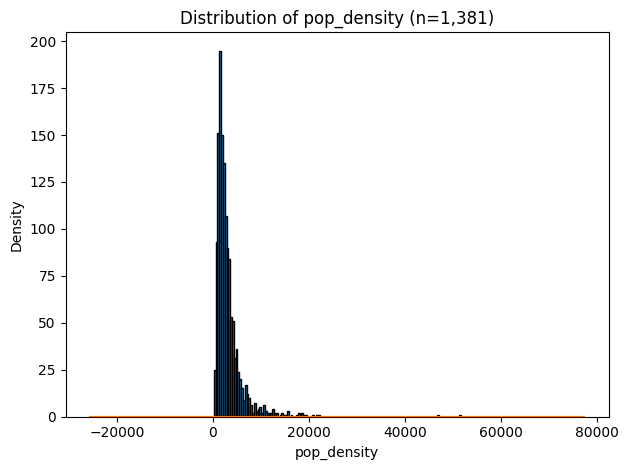

In [53]:
plot_distribution(merged, 'pop_density')

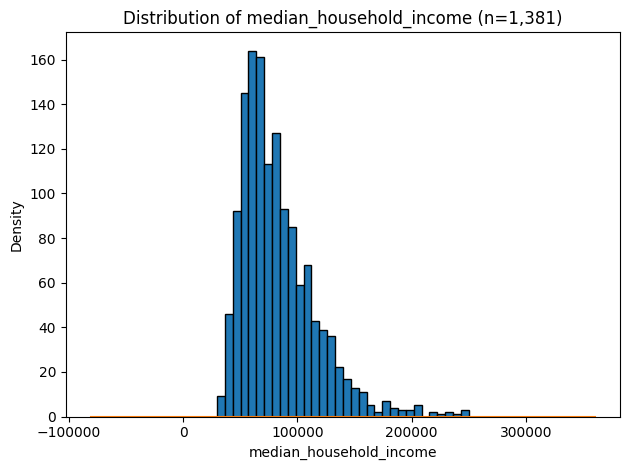

In [33]:
plot_distribution(merged, 'median_household_income')

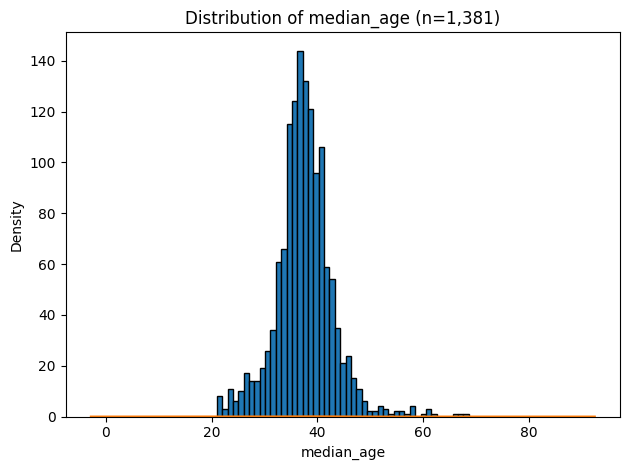

In [46]:
plot_distribution(merged, 'median_age')

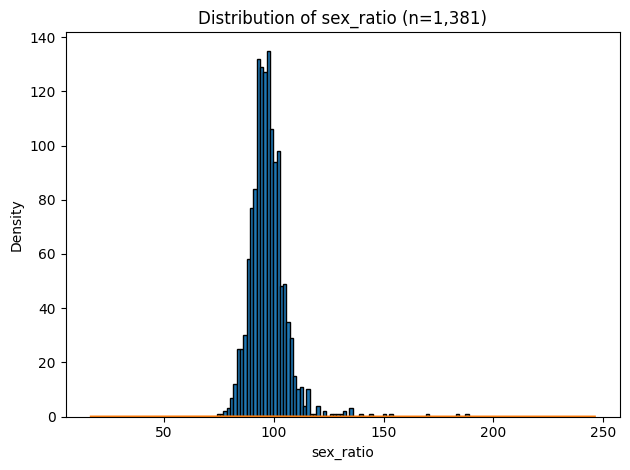

In [47]:
plot_distribution(merged, 'sex_ratio')

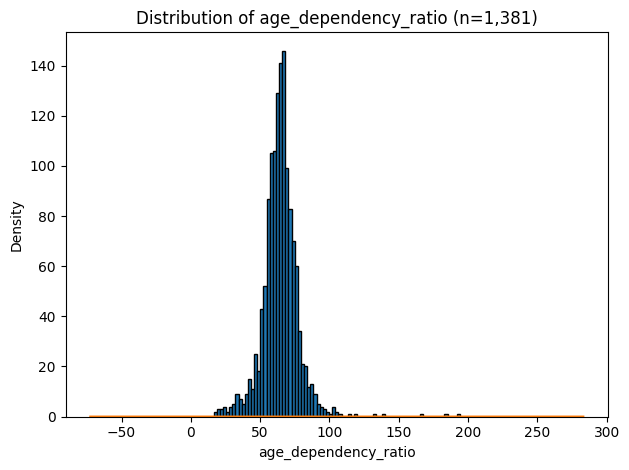

In [48]:
plot_distribution(merged, 'age_dependency_ratio')

In [55]:
cols = [
    "median_household_income",
    "median_age",
    "sex_ratio",
    "age_dependency_ratio",
    "pop_density",
]

# Ensure numeric (safe if some came in as strings)
merged[cols] = merged[cols].apply(pd.to_numeric, errors="coerce")

center_width = 0.20
lo_q = (1 - center_width) / 2.0   # 0.40
hi_q = 1 - lo_q                   # 0.60

# Compute per-column thresholds
qs = merged[cols].quantile([lo_q, hi_q])
lo = qs.loc[lo_q]
hi = qs.loc[hi_q]

# Build mask: row must fall within [40th, 60th] for every selected column
mask = np.ones(len(merged), dtype=bool)
for c in cols:
    mask &= merged[c].between(lo[c], hi[c], inclusive="both")

central20_all = merged[mask].copy()

# Optional: inspect thresholds and how many rows kept
print("40th percentiles:\n", lo)
print("\n60th percentiles:\n", hi)
print(f"\nRows in central 20% for ALL five metrics: {mask.sum()} of {len(merged)}")

# central20_all is your result


40th percentiles:
 median_household_income    68386.000000
median_age                    36.400000
sex_ratio                     94.700000
age_dependency_ratio          62.200000
pop_density                 1926.206756
Name: 0.4, dtype: float64

60th percentiles:
 median_household_income    82847.000000
median_age                    38.500000
sex_ratio                     97.900000
age_dependency_ratio          66.500000
pop_density                 2764.636478
Name: 0.6, dtype: float64

Rows in central 20% for ALL five metrics: 2 of 1384


In [56]:
central20_all

,Place,Pop2024,type,city_raw,state_raw,USPS,city_norm,ALAND_SQMI,AWATER_SQMI,ALAND,...,total_population,pop_in_households,median_household_income,median_age,sex_ratio,age_dependency_ratio,old_age_dependency_ratio,child_dependency_ratio,pct_diff,pop_density
951,"Fairfield city, Ohio",45094.0,city,Fairfield city,Ohio,OH,fairfield city,20.832,0.087,53955167,...,44597.0,44066.0,70166.0,38.3,95.8,64.5,28.2,36.3,-1.190663,2140.793011
1098,"Simpsonville city, South Carolina",28078.0,city,Simpsonville city,South Carolina,SC,simpsonville city,9.705,0.020,25135975,...,25125.0,24929.0,79233.0,36.4,96.4,63.8,22.9,40.9,-0.780100,2588.871716


In [ ]:
under_3pct_df = merged[merged["pct_diff"].abs() < 5]
under_3pct_df

,Place,Pop2024,type,city_raw,state_raw,USPS,city_norm,ALAND_SQMI,AWATER_SQMI,ALAND,AWATER,area_sqmi,area_total_sqmi,total_population,pop_in_households,pct_diff,pop_density
0,"Alabaster city, Alabama",34460.0,city,Alabaster city,Alabama,AL,alabaster city,26.255,0.317,68000038,820693,26.255,26.572,33633.0,33281.0,-1.046591,1281.013140
1,"Albertville city, Alabama",23392.0,city,Albertville city,Alabama,AL,albertville city,26.972,0.094,69856181,244058,26.972,27.066,22584.0,22279.0,-1.350514,837.312769
3,"Athens city, Alabama",32587.0,city,Athens city,Alabama,AL,athens city,41.838,0.289,108360634,748132,41.838,42.127,27474.0,26818.0,-2.387712,656.675749
5,"Bessemer city, Alabama",25079.0,city,Bessemer city,Alabama,AL,bessemer city,40.639,0.212,105254903,548067,40.639,40.851,25655.0,24971.0,-2.666147,631.290140
6,"Cullman city, Alabama",20239.0,city,Cullman city,Alabama,AL,cullman city,22.827,1.339,59121907,3468382,22.827,24.166,18894.0,18231.0,-3.509050,827.704035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,"West Bend city, Wisconsin",32149.0,city,West Bend city,Wisconsin,WI,west bend city,15.565,0.156,40313488,403725,15.565,15.721,31722.0,31262.0,-1.450098,2038.034051
1379,"Casper city, Wyoming",58823.0,city,Casper city,Wyoming,WY,casper city,26.753,0.335,69290824,866721,26.753,27.088,58754.0,57703.0,-1.788814,2196.164916
1380,"Cheyenne city, Wyoming",65704.0,city,Cheyenne city,Wyoming,WY,cheyenne city,36.474,0.112,94467889,290954,36.474,36.586,64976.0,64199.0,-1.195826,1781.433350
1381,"Gillette city, Wyoming",33846.0,city,Gillette city,Wyoming,WY,gillette city,23.192,0.038,60066932,99326,23.192,23.230,33278.0,32866.0,-1.238055,1434.891342
